------------------

# NLP - Word Embedding

------------------

### **Imdb Dataset:**

Link for Dataset: http://ai.stanford.edu/~amaas/data/sentiment/

Citation for Dataset:<br>
```
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
```


In [5]:
# Install this package if running on your local machine
# !pip install -q tensorflow-datasets

In [8]:
import tensorflow as tf
import numpy as np, pandas as pd
import tensorflow_datasets as tfds
print(tf.__version__)

2.10.1


In [45]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [46]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\nitan\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num

In [47]:
print(imdb)

# Take 2 training examples and print its contents
for example in imdb['train'].take(2):
  print(example)

{'train': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}
(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plu

In [49]:
train_data, test_data = imdb['train'], imdb['test']

In [50]:
# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [52]:
training_labels_final.max()

1

: 

### Generate Padded Sequences

In [14]:
# Parameters

vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)

### Building the Model

With the data already preprocessed, you can proceed to building your sentiment classification model. The input will be an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. The main idea here is to represent each word in your vocabulary with vectors. These vectors have trainable weights so as your neural network learns, words that are most likely to appear in a positive tweet will converge towards similar weights. Similarly, words in negative tweets will be clustered more closely together. You can read more about word embeddings [here](https://www.tensorflow.org/text/guide/word_embeddings).

After the `Embedding` layer, you will flatten its output and feed it into a `Dense` layer. You will explore other architectures for these hidden layers in the next labs.

The output layer would be a single neuron with a sigmoid activation to distinguish between the 2 classes. As is typical with binary classifiers, you will use the `binary_crossentropy` as your loss function while training.

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                              embedding_dim, 
                              input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [17]:
num_epochs = 10

# Train the model
model.fit(padded, 
          training_labels_final, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.4949 - accuracy: 0.7418 - val_loss: 0.2507 - val_accuracy: 0.9069
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2368 - accuracy: 0.9068 - val_loss: 0.0987 - val_accuracy: 0.9790
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0826 - accuracy: 0.9797 - val_loss: 0.0256 - val_accuracy: 0.9970
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0203 - accuracy: 0.9975 - val_loss: 0.0065 - val_accuracy: 0.9995
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0057 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 8.4640e-04 - accuracy: 1.0000 - val_loss: 5.2705e-04 - val_accuracy: 1.00

### Visualize Word Embeddings

After training, you can visualize the trained weights in the `Embedding` layer to see words that are clustered together. The [Tensorflow Embedding Projector](https://projector.tensorflow.org/) is able to reduce the 16-dimension vectors you defined earlier into fewer components so it can be plotted in the projector. First, you will need to get these weights and you can do that with the cell below:

In [18]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [19]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

You will need to generate two files:

* `vecs.tsv` - contains the vector weights of each word in the vocabulary
* `meta.tsv` - contains the words in the vocabulary


For this, it is useful to have `reverse_word_index` dictionary so you can quickly lookup a word based on a given index. For example, `reverse_word_index[1]` will return your OOV token because it is always at index = 1. Fortunately, the `Tokenizer` class already provides this dictionary through its `index_word` property. Yes, as the name implies, it is the reverse of the `word_index` property which you used earlier!

Now you can start the loop to generate the files. You will loop `vocab_size-1` times, skipping the `0` key because it is just for the padding.

In [20]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

### **Sentiment Analysis Dataset:**

'sacracsm.json'

In [27]:
import json

# # Download the dataset
# import wget
# wget.download("https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json", "sacracsm.json")

# Load the JSON file
with open("sacracsm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

### Hyperparameters

In [28]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

### Splitting the Data

In [29]:
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### Preprocessing the train and test sets

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, 
                                maxlen=max_length, 
                                padding=padding_type, 
                                truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, 
                               maxlen=max_length, 
                               padding=padding_type, 
                               truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Build and Compile the Model

Next, you will build the model. The architecture is similar to the previous lab but you will use a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays (i.e. `(10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [31]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


This added computation reduces the dimensionality of the model as compared to using `Flatten()` and thus, the number of training parameters will also decrease. See the output of `model.summary()` below and see how it compares if you swap out the pooling layer with a simple `Flatten()`.

In [32]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train the Model

Now you will feed in the prepared datasets to train the model. If you used the default hyperparameters, you will get around 99% training accuracy and 80% validation accuracy.

*Tip: You can set the `verbose` parameter of `model.fit()` to `2` to indicate that you want to print just the results per epoch. Setting it to `1` (default) displays a progress bar per epoch, while `0` silences all displays. It doesn't matter much in this Colab but when working in a production environment, you may want to set this to `2` as recommended in the [documentation](https://keras.io/api/models/model_training_apis/#fit-method).*

In [34]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 5s - loss: 0.5744 - accuracy: 0.6936 - val_loss: 0.4036 - val_accuracy: 0.8323 - 5s/epoch - 7ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3136 - accuracy: 0.8719 - val_loss: 0.3449 - val_accuracy: 0.8527 - 4s/epoch - 7ms/step
Epoch 3/30
625/625 - 4s - loss: 0.2362 - accuracy: 0.9064 - val_loss: 0.3409 - val_accuracy: 0.8548 - 4s/epoch - 6ms/step
Epoch 4/30
625/625 - 4s - loss: 0.1912 - accuracy: 0.9260 - val_loss: 0.3633 - val_accuracy: 0.8477 - 4s/epoch - 6ms/step
Epoch 5/30
625/625 - 4s - loss: 0.1592 - accuracy: 0.9402 - val_loss: 0.3827 - val_accuracy: 0.8535 - 4s/epoch - 6ms/step
Epoch 6/30
625/625 - 4s - loss: 0.1366 - accuracy: 0.9512 - val_loss: 0.4093 - val_accuracy: 0.8490 - 4s/epoch - 6ms/step
Epoch 7/30
625/625 - 4s - loss: 0.1160 - accuracy: 0.9603 - val_loss: 0.4464 - val_accuracy: 0.8438 - 4s/epoch - 6ms/step
Epoch 8/30
625/625 - 4s - loss: 0.1011 - accuracy: 0.9665 - val_loss: 0.4839 - val_accuracy: 0.8402 - 4s/epoch - 6ms/step
Epoch 9/30
625/625 - 4s 

### Visualize the Results

You can use the cell below to plot the training results. You may notice some overfitting because your validation accuracy is slowly dropping while the training accuracy is still going up. See if you can improve it by tweaking the hyperparameters. Some example values are shown in the lectures.

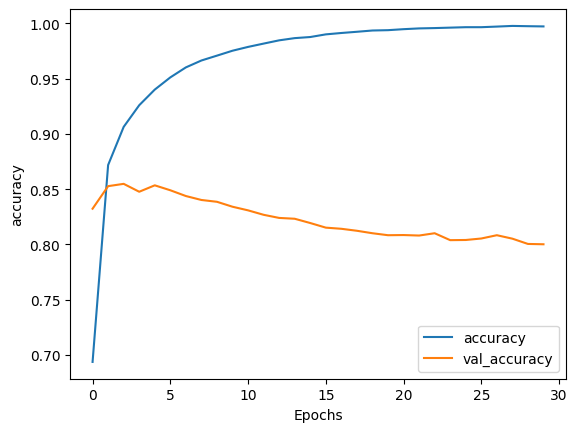

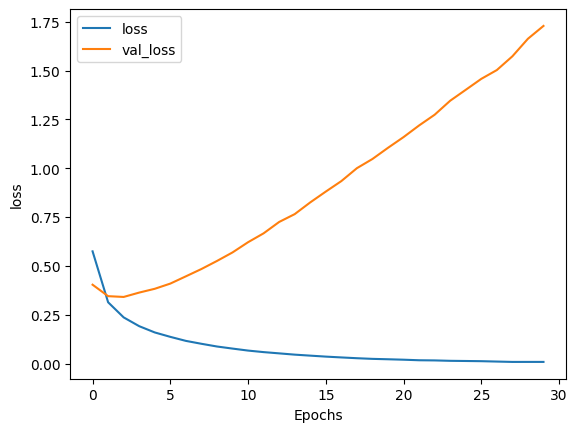

In [37]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Visualize Word Embeddings

As before, you can visualize the final weights of the embeddings using the [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

In [35]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 


(10000, 16)


In [36]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

### **Pre-Tokenized Datasets**

- https://github.com/tensorflow/datasets/tree/master/docs/catalog
- https://www.tensorflow.org/datasets/catalog/overview

#### **Subwords Text Encoder**

https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder



### Download the IMDB reviews plain text and tokenized datasets

First, you will download the [IMDB Reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) dataset from Tensorflow Datasets. You will get two configurations:

* `plain_text` - this is the default and the one you used in Lab 1 of this week
* `subwords8k` - a pre-tokenized dataset (i.e. instead of sentences of type string, it will already give you the tokenized sequences). You will see how this looks in later sections.

In [38]:
# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\nitan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete903ZR3\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\nitan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete903ZR3\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\nitan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incomplete903ZR3\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\nitan\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


### Comparing the two datasets

As mentioned, the data types returned by the two datasets will be different. For the default, it will be strings as you also saw in Lab 1. Notice the description of the `text` key below and the sample sentences:

In [39]:
# Print description of features
info_plaintext.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})

In [40]:
# Take 2 training examples and print the text feature
for example in imdb_plaintext['train'].take(2):
  print(example[0].numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

For `subwords8k`, the dataset is already tokenized so the data type will be integers. Notice that the `text` features also include an `encoder` field and has a `vocab_size` of around 8k, hence the name.

In [41]:
# Print description of features
info_subwords.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [42]:
# Take 2 training examples and print its contents
for example in imdb_subwords['train'].take(2):
  print(example)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

You can get the `encoder` object included in the download and use it to decode the sequences above. 

You'll see that you will arrive at the same sentences provided in the `plain_text` config:

In [43]:
# Get the encoder
tokenizer_subwords = info_subwords.features['text'].encoder

# Take 2 training examples and decode the text feature
for example in imdb_subwords['train'].take(2):
  print(tokenizer_subwords.decode(example[0]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons